# Manipulate waveform decomposition frame and find corotating angles (use package class)

### Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
from matplotlib.pyplot import *
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *
from nrutils.manipulate.rotate import gwylm_radiation_axis_workflow 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(positive)>> Applying custom matplotlib settings.


### Find a simulation

In [2]:

# A = scsearch(keyword='q8a04t60_T_96_360',verbose=True)
# A = scsearch(institute='bam',keyword='q8a04t90_T_96_360',verbose=True)
# A = scsearch(institute='bam',keyword='q1a04t90',verbose=True)


# A = scsearch(institute='bam',keyword='q8a08t150',verbose=True)
A = scsearch(institute='bam',keyword='q4a08t120',verbose=True)


# A = scsearch(institute='bam',keyword='q1a04t30',verbose=True)

# A = scsearch(institute='bam',keyword='q4a08t30dPm4_T_96_360',verbose=True)

# A = scsearch(institute='gt',keyword='Sq4_d9_a0.6_oth.090_rr_M140',verbose=True)
# A = scsearch(q=1,keyword='hrq',verbose=True)
# A = scsearch(precessing=True,verbose=True)
# A = scsearch(keyword='EP_um2D10_d6_sz-n88')

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found keyword (=q4a08t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t120dP1_T_96_360)



### Load waveform data

In [3]:
print sign(A[0].S[-1])

-1.0


In [4]:
y = gwylm( A[0], lmax=2, verbose=True, clean=True, dt=0.5,pad=500 )

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found pad (=500) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x11f8cbab8>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default M_RELATIVE_SIGN_CONVENTION of 1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce monotinicity.
(straighten_wfarr!)>> The waveform time series is now mono

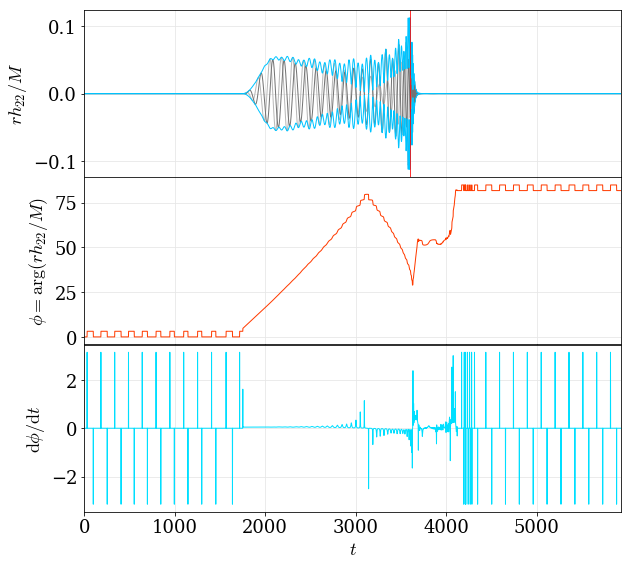

In [5]:
ax,fig = y[2,2]['strain'].plot()
sca(ax[0])
axvline( y[2,2]['strain'].t[y[2,2]['strain'].k_amp_max], color='r' )

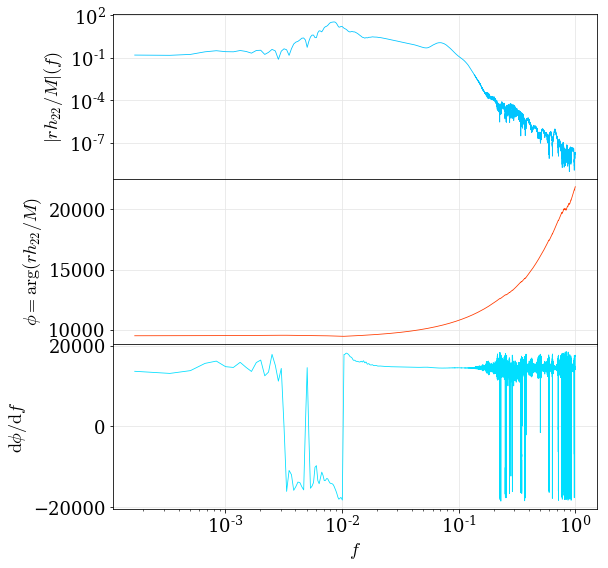

In [6]:
ax,fig = y[2,2]['strain'].plot(domain='freq')

### Initiate packed workflow

In [7]:
y.Xf

array([0.1478047, 0.3198709, 0.319068 ])

(gwylm_radiation_axis_workflow)>> Calculating Radiated Quantities
(gwylm_radiation_axis_workflow)>> Calculating TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Calculating FD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting FD Radiation Axis Series


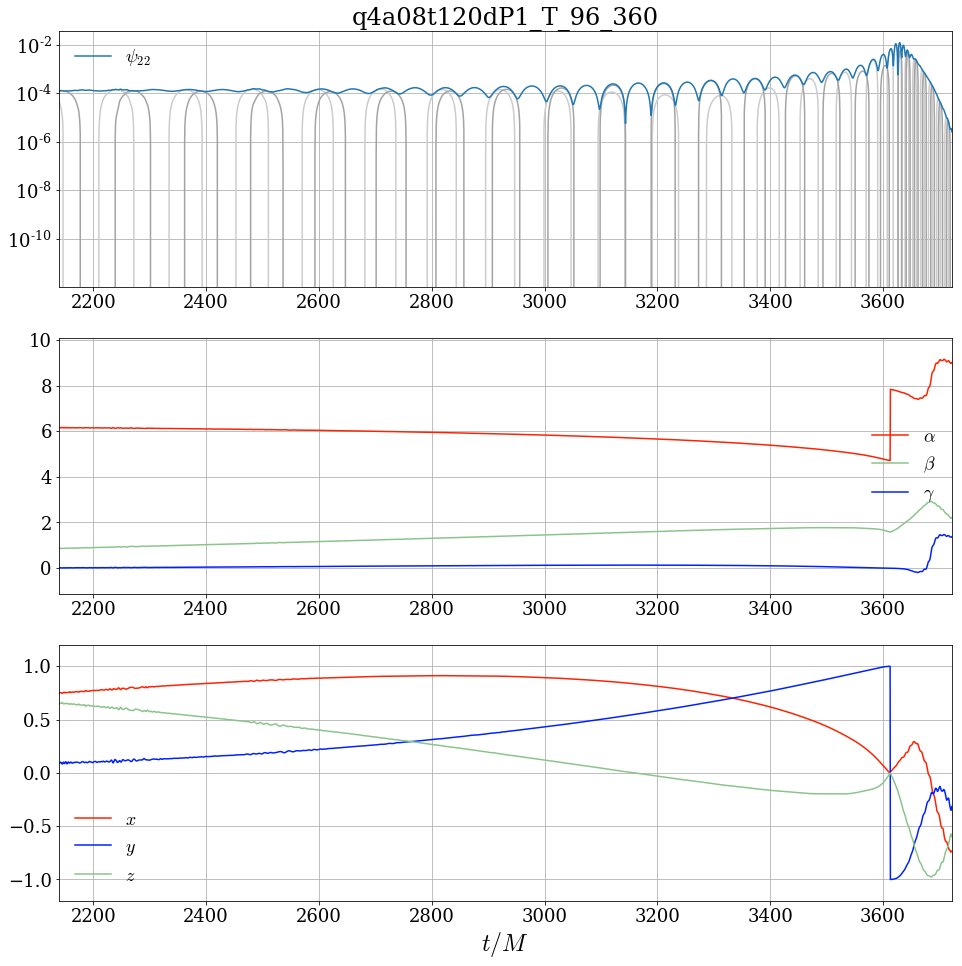

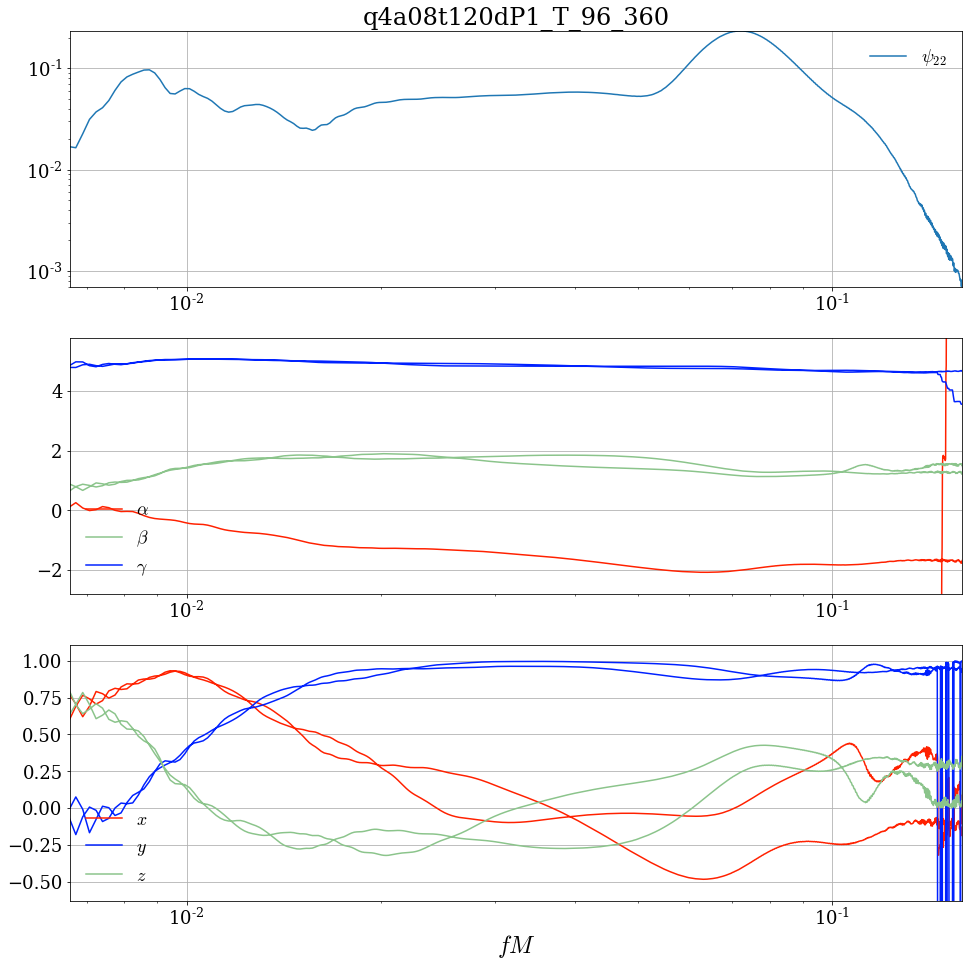

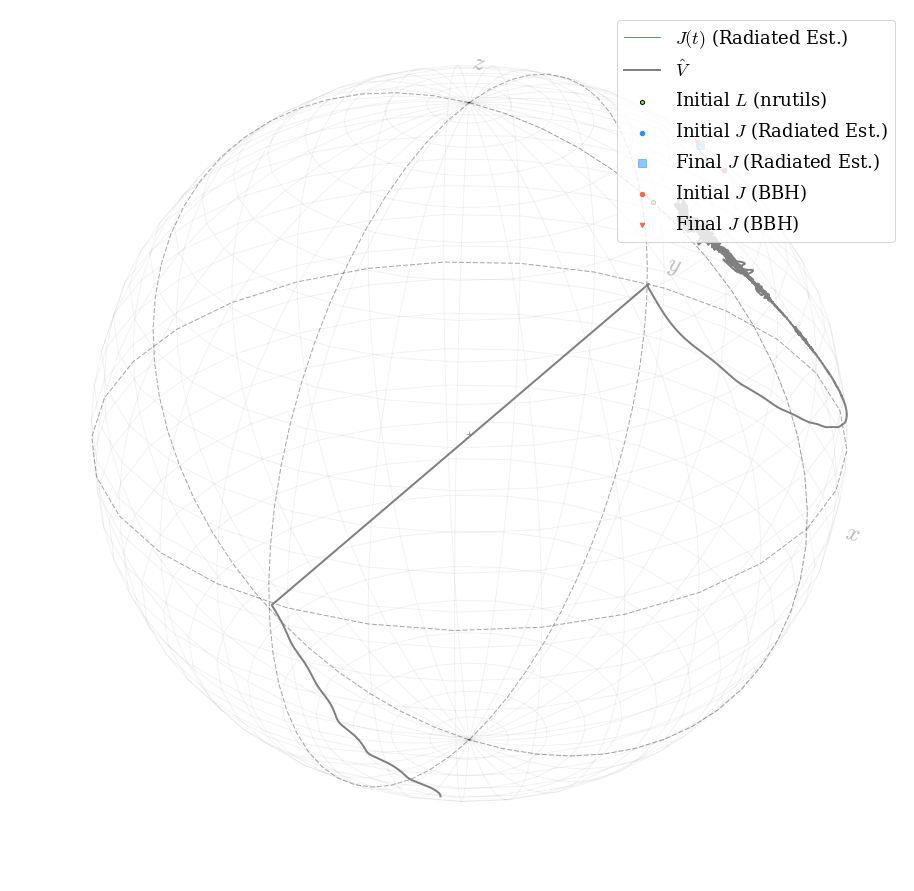

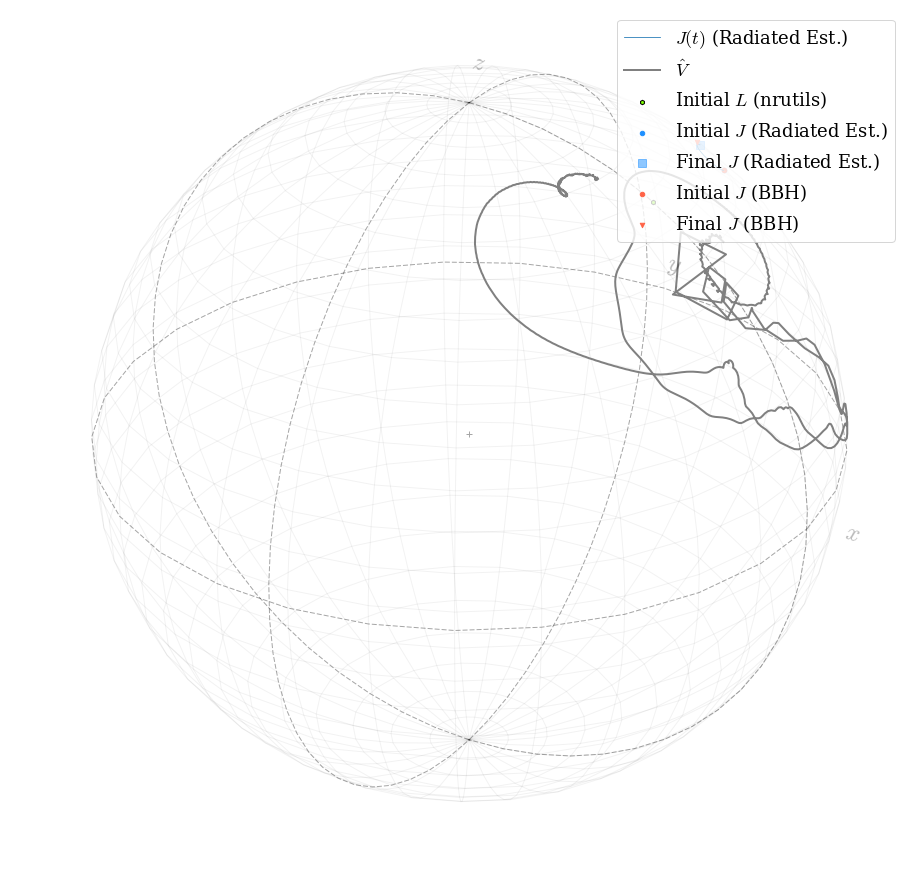

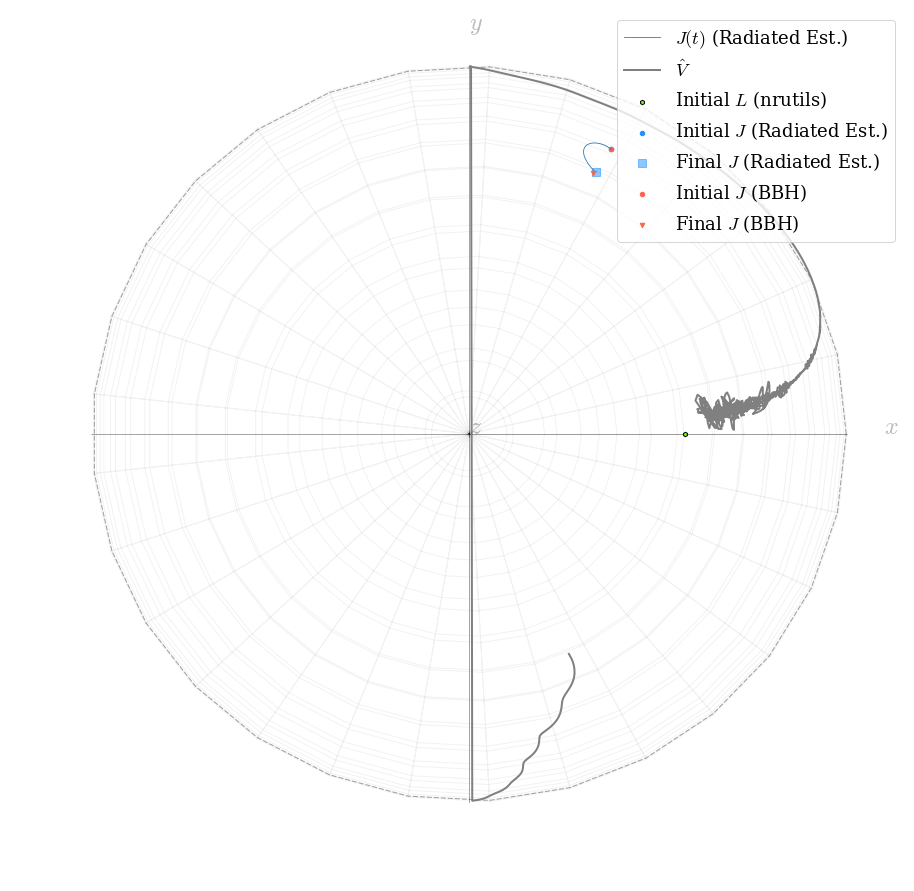

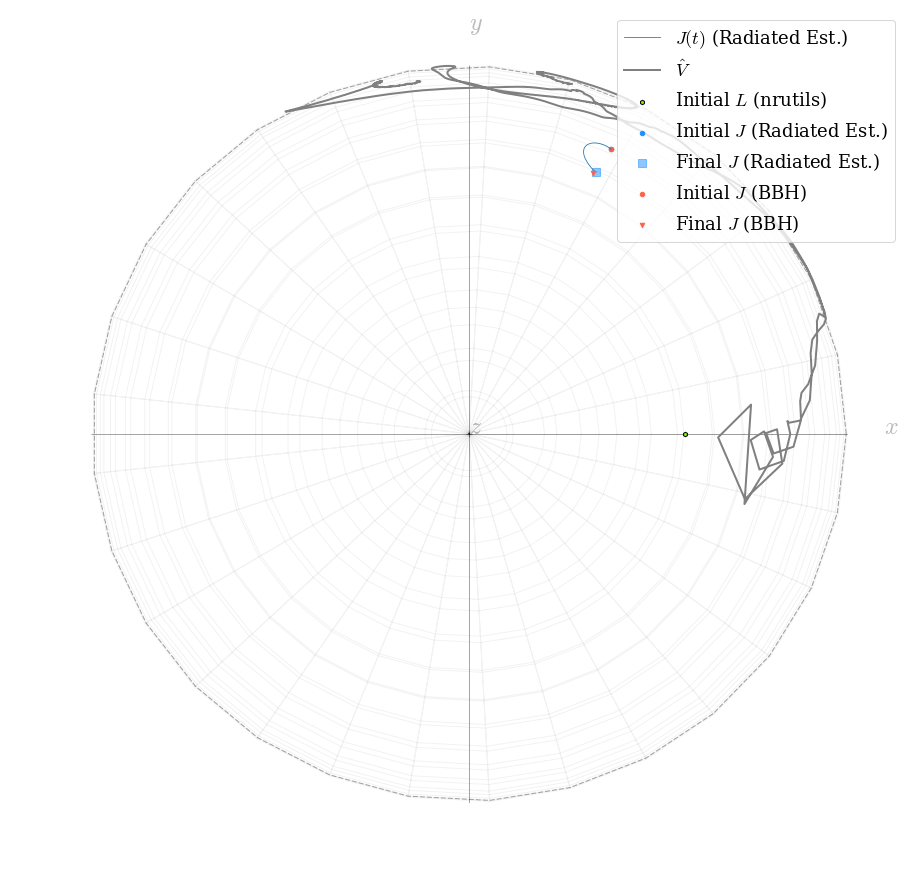

In [8]:
foo = gwylm_radiation_axis_workflow( y, plot=True, save=False )

In [9]:
print foo.__dict__.keys()
print foo.radiation_axis.keys()

['save', 'gwylmo', 'radiation_axis']
['fd_domain', 'td_alpha', 'fd_alpha', 'td_gamma', 'fd_beta', 'fd_z', 'td_beta', 'fd_x', 'fd_gamma', 'td_domain', 'td_y', 'td_x', 'td_z', 'fd_y']


## Inspect simulation dynamics when J_initial || z; that is, perform rotations to rotate quantities accordingly.

In [10]:

# Calculate the initial J 

# k = 0
# J = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )

S1 = array([ y.raw_metadata.initial_bh_spin2x, y.raw_metadata.initial_bh_spin2y, y.raw_metadata.initial_bh_spin2z])
S2 = array([ y.raw_metadata.initial_bh_spin1x, y.raw_metadata.initial_bh_spin1y, y.raw_metadata.initial_bh_spin1z])
S = S1+S2
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
J = (L+S)/linalg.norm( L+S )

# Calculate angles required to rotate J into z direction
Jx,Jy,Jz = J
# NOTE that the minus signs here signify that we are totating the opposite dirction in which the angles are computed
beta = -arccos( Jz/linalg.norm(J) )
gamma = -arctan2( Jy,Jx )

# Define zeta (i.e. -alpha) such that L is along the y-z plane
L = (y.L1 + y.L2) / linalg.norm(y.L1 + y.L2) 
L_ = rotate3 ( L, 0, beta, gamma )
zeta = arctan2( L_[1], L_[0] )

#
alpha = -zeta

#
angles = [alpha,beta,gamma]

# 
alert( 'Rotating J along the z direction should yield [0,0,1] below:' )
print 'J = ',J
print '  = ',rotate3( J, alpha,beta,gamma)
print 'L = ',L
print '  = ',rotate3( L, alpha,beta,gamma)

#
print '* ', dot(L,J)
print '* ', dot(rotate3( L, alpha,beta,gamma),rotate3( J, alpha,beta,gamma))

#
print 'alpha \t= ',alpha
print 'beta  \t= ',beta
print 'gamma \t= ',gamma

# Perform rotation
g = y.__rotate_frame_at_all_times__(angles)

#
print  (g.L1 + g.L2) / linalg.norm(g.L1 + g.L2) 

(notebook)>> Rotating J along the z direction should yield [0,0,1] below:
J =  [0.35943131 0.73969007 0.56891804]
  =  [-5.55111512e-17  0.00000000e+00  1.00000000e+00]
L =  [0.53411405 0.         0.84541243]
  =  [7.39690067e-01 5.55111512e-17 6.72947699e-01]
*  0.6729476987167419
*  0.672947698716742
alpha 	=  2.4347155599777417
beta  	=  -0.9656066897720402
gamma 	=  -1.1184748158294913
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.
[7.39690067e-01 1.05020426e-17 6.72947699e-01]


(gwylm_radiation_axis_workflow)>> Calculating Radiated Quantities
(gwylm_radiation_axis_workflow)>> Calculating TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Calculating FD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting FD Radiation Axis Series


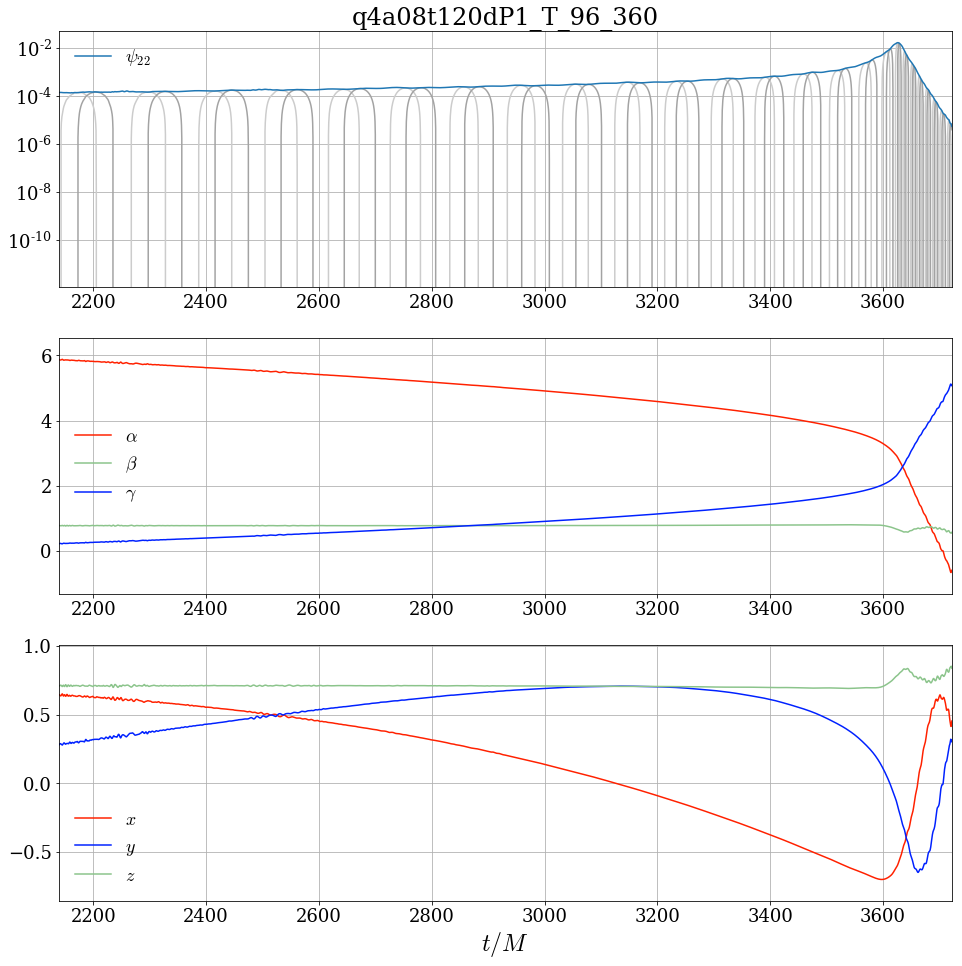

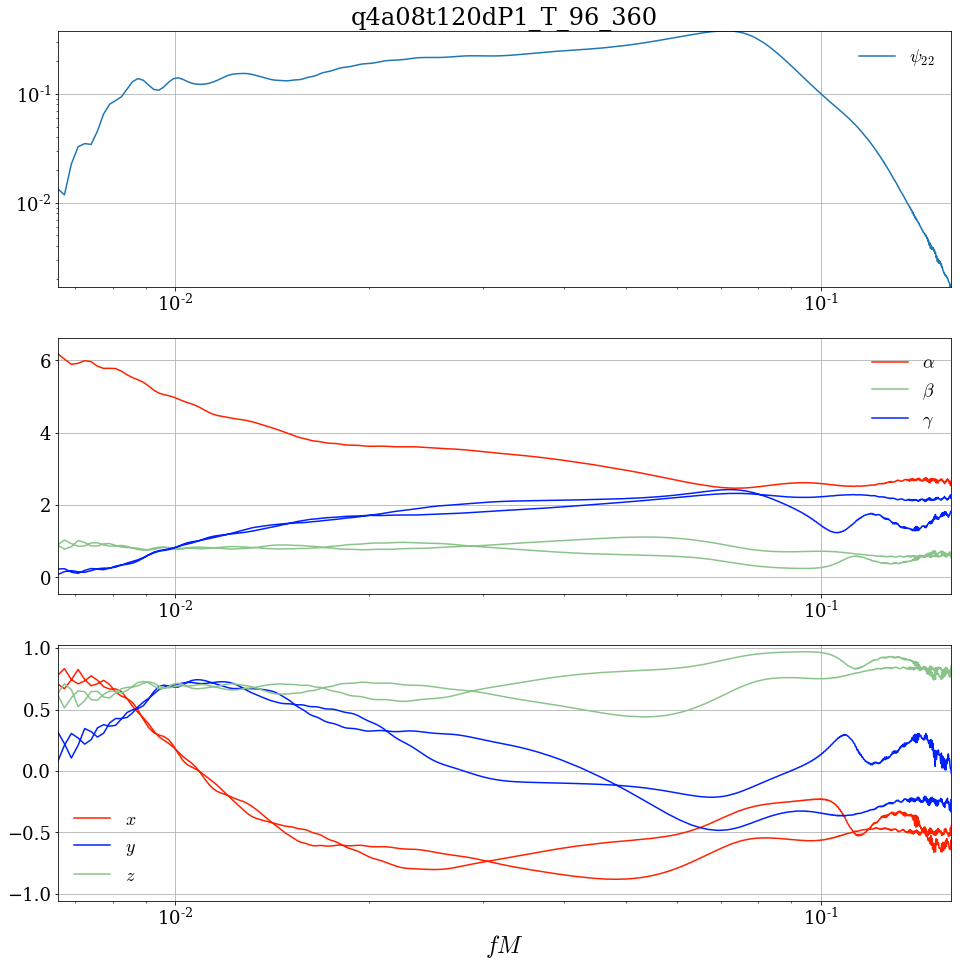

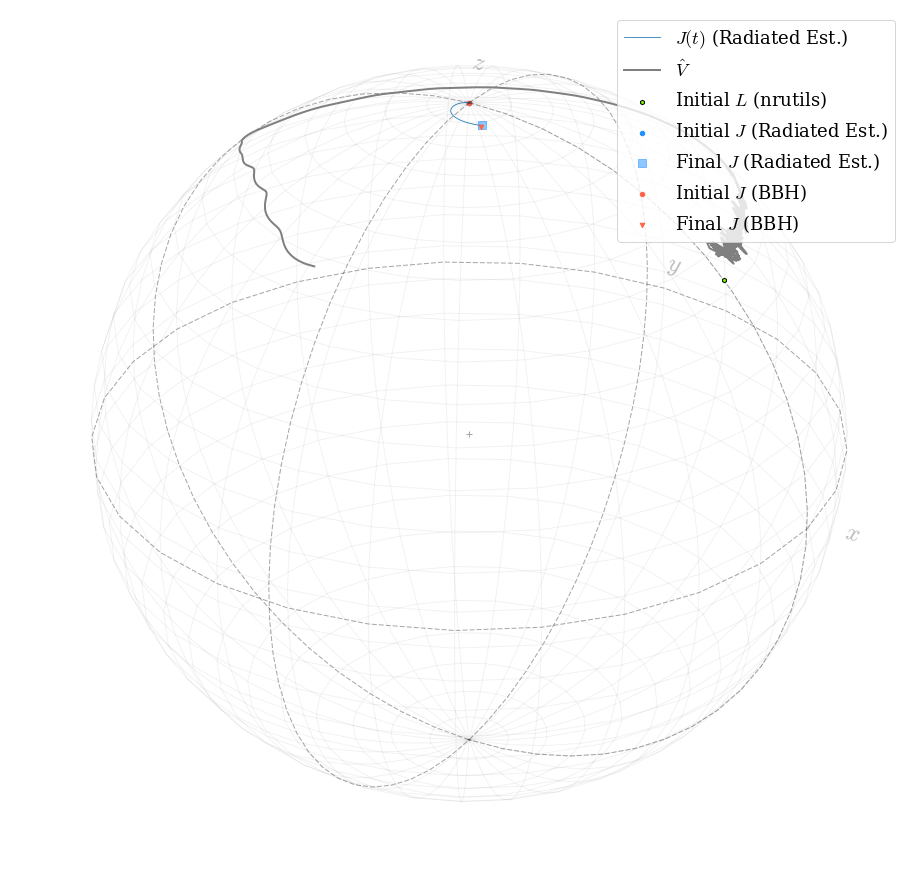

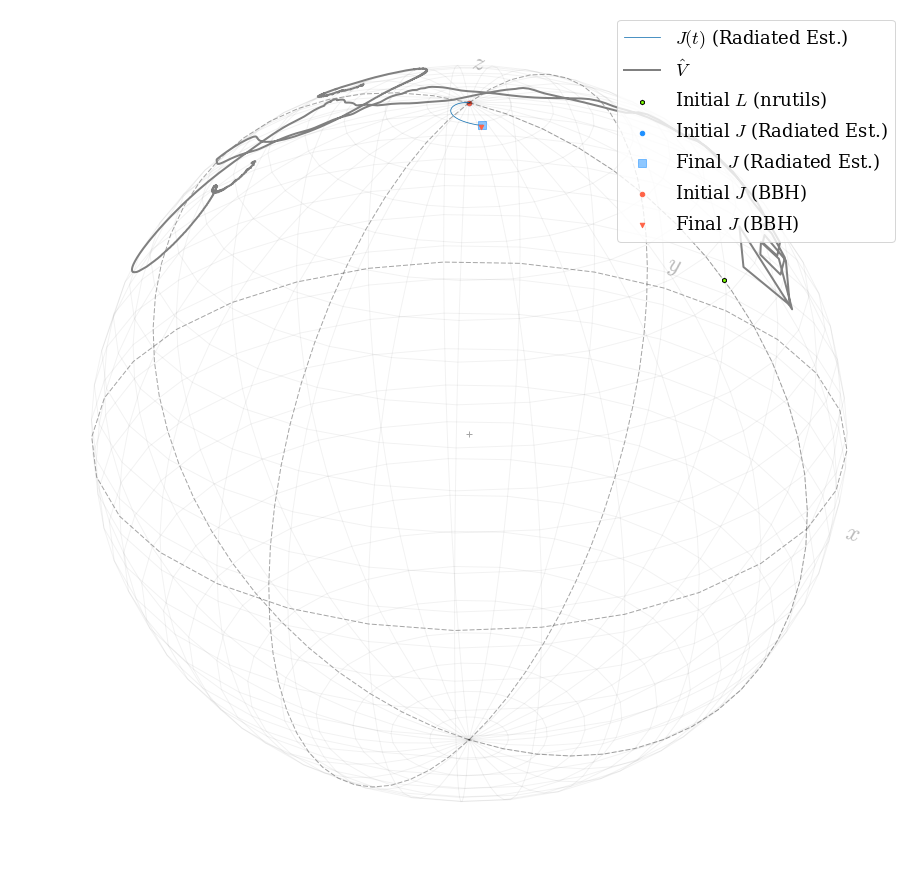

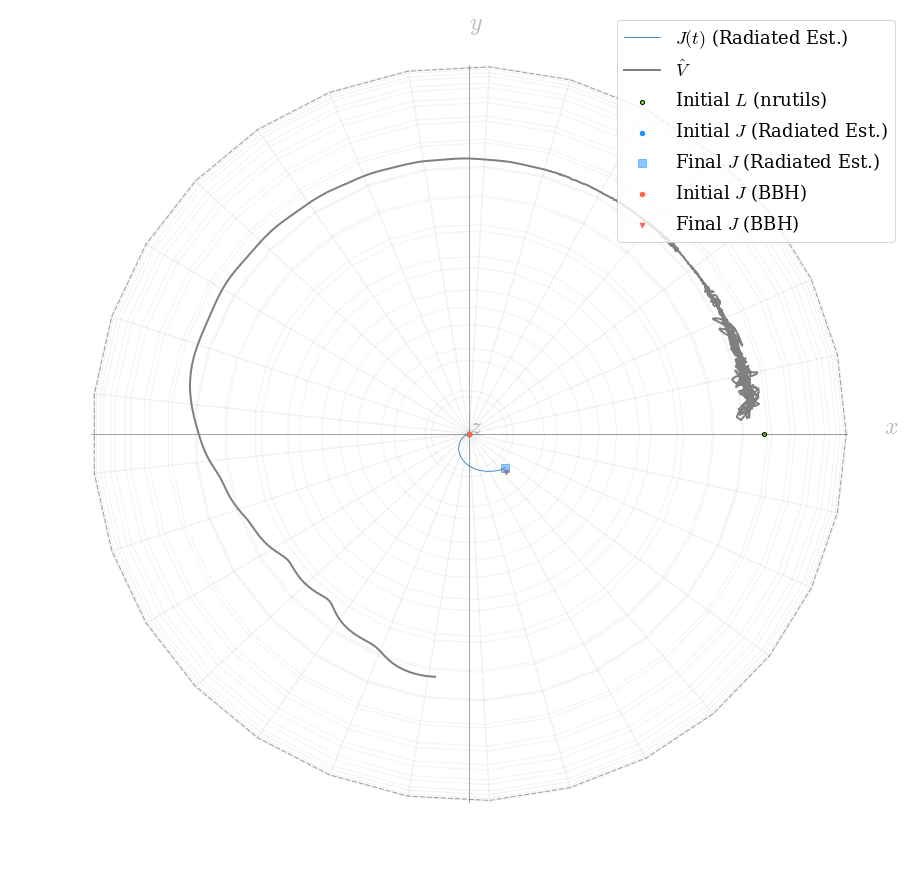

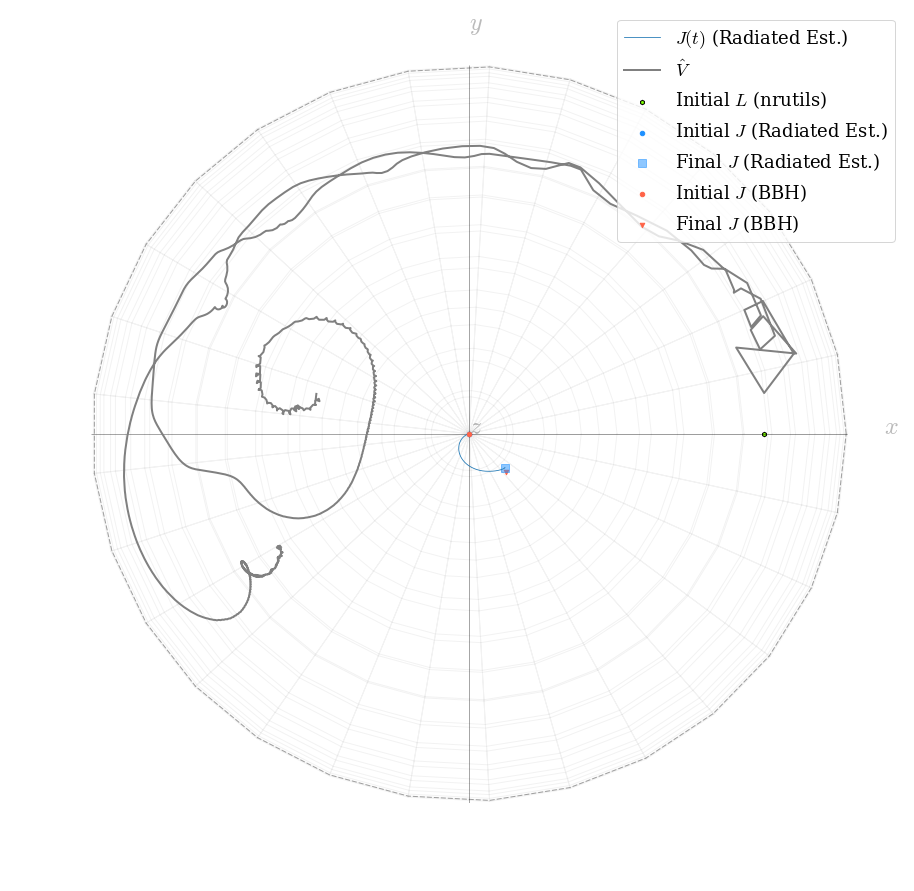

In [11]:
bar = gwylm_radiation_axis_workflow( g, outdir='/Users/book/Desktop/%s_J0_aligned'%g.simname, plot=True,save=False )

## Co-Preceissing Frame (TD) waveform

In [12]:

alpha = bar.radiation_axis['td_alpha']
beta = bar.radiation_axis['td_beta']
gamma = bar.radiation_axis['td_gamma']
g_qa_td = g.__rotate_frame_at_all_times__( [gamma,-beta,alpha] )


(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [13]:
star = gwylm_radiation_axis_workflow( g_qa_td, outdir='/Users/book/Desktop/%s_QA'%g_qa_td.simname )

(gwylm_radiation_axis_workflow)>> Calculating Radiated Quantities
(mkdir)>> Directory at "/Users/book/Desktop/q4a08t120dP1_T_96_360_QA" already exists and will be not be altered or created..
(gwylm_radiation_axis_workflow)>> Calculating TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Calculating FD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting TD Radiation Axis Series
(gwylm_radiation_axis_workflow)>> Plotting FD Radiation Axis Series


## Calculate FD Co-Precessing Multipoles and then IFFT

In [14]:

# Store Multipoles for J-aligned waveform
kind = 'psi4'
mp_jaligned = { (l,m):array([g[l,m][kind].f,g[l,m][kind].fd_plus,g[l,m][kind].fd_cross]).T for l,m in g.lm if l==2 }

# Compute Coprecessing waveform in FD
alpha = bar.radiation_axis['fd_alpha']
beta = bar.radiation_axis['fd_beta']
gamma = bar.radiation_axis['fd_gamma']
mp_copreces = { (l,m):rotate_wfarrs_at_all_times( l,m, mp_jaligned, ( gamma, -beta, alpha ) ) for l,m in mp_jaligned if l==2 }

(-0.16, 0.16)

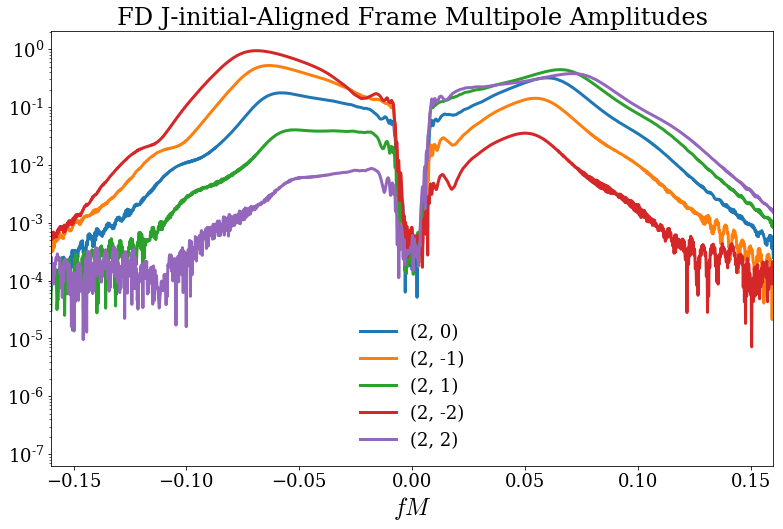

In [15]:
# Plot multipole amplitudes in FD J-aligned frame
figure( figsize=2*figaspect(0.618) )
mp_of_interest = mp_jaligned
for lm in mp_copreces:
    plot( bar.radiation_axis['fd_domain'], abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2]),label=lm,lw=3 )
yscale('log')
xlabel('$fM$')
legend()
title('FD J-initial-Aligned Frame Multipole Amplitudes')
xlim([-0.16,0.16])

(-0.16, 0.16)

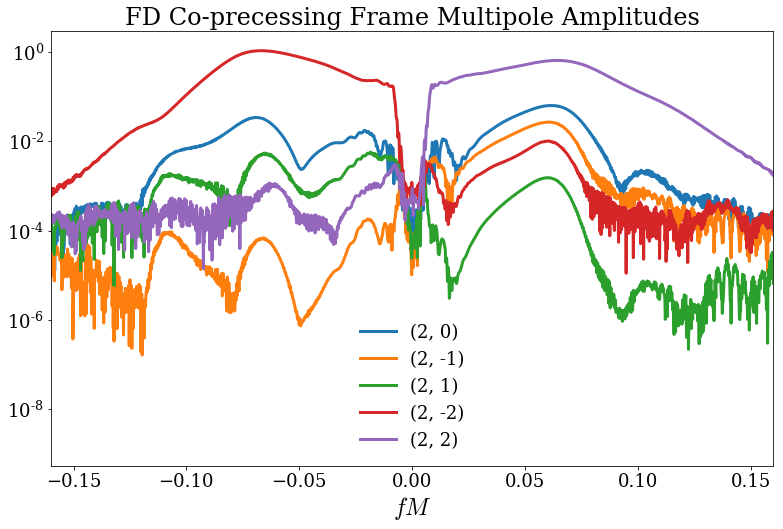

In [16]:
# Plot multipole amplitudes in FD co-precessing frame
figure( figsize=2*figaspect(0.618) )
mp_of_interest = mp_copreces
for lm in mp_copreces:
    plot( bar.radiation_axis['fd_domain'], abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2]),label=lm,lw=3 )
yscale('log')
xlabel('$fM$')
legend()
title('FD Co-precessing Frame Multipole Amplitudes')
xlim([-0.16,0.16])

In [17]:
# Compute ifft of coprecessing FD waveforms
from scipy.fftpack import fft, fftfreq, fftshift, ifft
f = bar.radiation_axis['fd_domain']
df = f[1]-f[0]
t = bar.radiation_axis['td_domain']
N = len(f)
td_mp_copreces = { lm: array([t,ifft( fftshift(mp_copreces[lm][:,1]) )*df*N,ifft( fftshift(mp_copreces[lm][:,2]) )*df*N]).T for lm in mp_copreces }

Text(0.5,1,u'q4a08t120dP1_T_96_360: TD Co-precessing Frame Multipole Amplitudes')

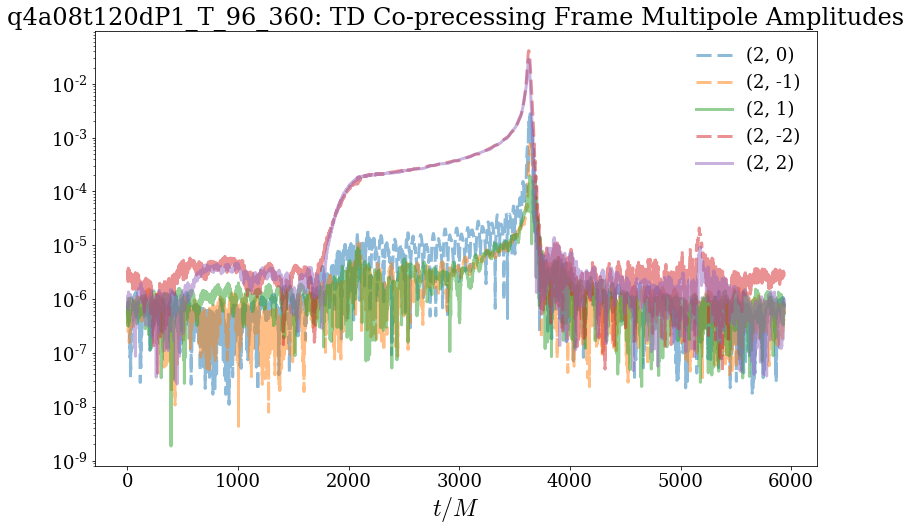

In [18]:
# Plot as a sanity check
figure( figsize=2*figaspect(0.618) )
mp_of_interest = td_mp_copreces
for lm in mp_copreces:
    plot( bar.radiation_axis['td_domain'], abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2]),label=lm,lw=3, alpha=0.5, ls = '-' if lm[-1]>0 else '--' )
yscale('log')
xlabel('$t/M$')
legend()
title('%s: TD Co-precessing Frame Multipole Amplitudes'%bar.gwylmo.simname)
# xlim([2500,6500])

Text(0.5,1,u'q4a08t120dP1_T_96_360: TD J-Aligned Frame Multipole Amplitudes')

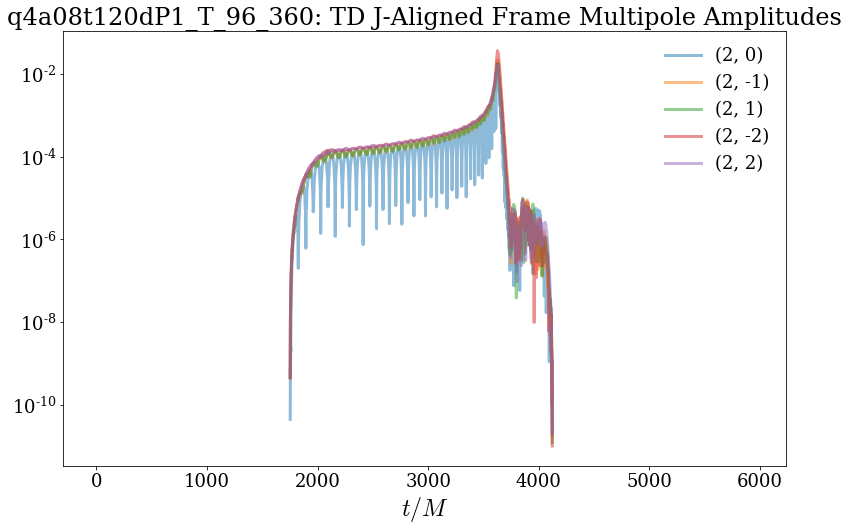

In [19]:
# Plot as a sanity check
figure( figsize=2*figaspect(0.618) )
mp_of_interest = { lm:g[lm][kind].wfarr for lm in g.lm }
for lm in mp_copreces:
    plot( bar.radiation_axis['td_domain'], abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2]),label=lm,lw=3, alpha=0.5 )
yscale('log')
xlabel('$t/M$')
legend()
title('%s: TD J-Aligned Frame Multipole Amplitudes'%bar.gwylmo.simname)
# xlim([2500,6500])

/Users/book/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5,1,u'q4a08t120dP1_T_96_360: TD Co-precessing Frame Multipole Amplitudes')

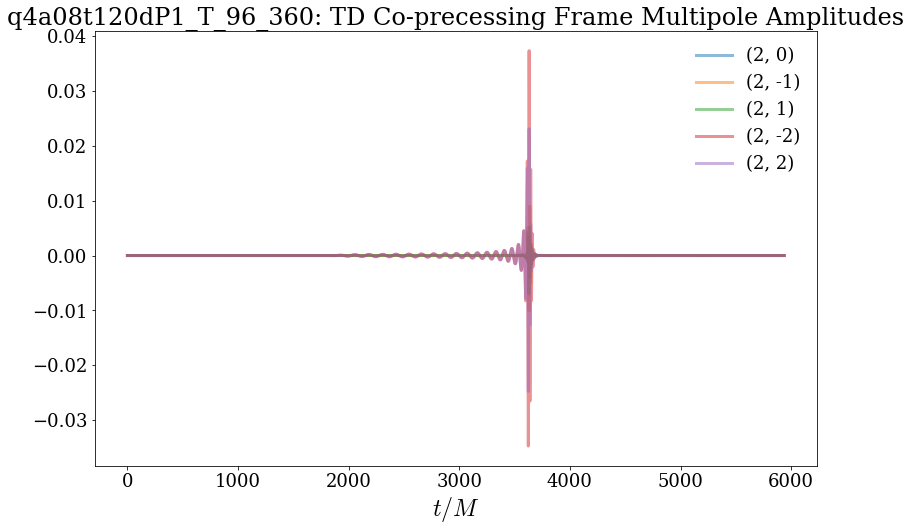

In [20]:
# Plot as a sanity check
figure( figsize=2*figaspect(0.618) )
mp_of_interest = td_mp_copreces
for lm in mp_copreces:
    plot( bar.radiation_axis['td_domain'], mp_of_interest[lm][:,1],label=lm,lw=3, alpha=0.5 )
# yscale('log')
xlabel('$t/M$')
legend()
title('%s: TD Co-precessing Frame Multipole Amplitudes'%bar.gwylmo.simname)
# xlim([5500,6000])

In [21]:

# lm = (2,2)

# figure( figsize=2*figaspect(0.618) )

# # mp_of_interest_interest = td_mp_copreces
# # plot( bar.radiation_axis['td_domain'], abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2]),label=lm,lw=3, alpha=0.5 )

# mp_of_interest_interest = { (l,m):g_qa_td[l,m][kind].wfarr for (l,m) in g_qa_td.lm }
# plot( bar.radiation_axis['td_domain'], abs(abs(mp_of_interest[lm][:,1]+1j*mp_of_interest[lm][:,2])-abs(td_mp_copreces[lm][:,1]+1j*td_mp_copreces[lm][:,2])),label=lm,lw=3, alpha=0.5 )

# # yscale('log')
